# Wind Speed Experiment Results Visualization

This notebook loads and visualizes the results from the wind speed regression experiments using the SparseGRF kernel.

The experiments evaluate wind speed prediction on ERA5 grid data with Aeolus satellite track training data across different numbers of random walkers and multiple random seeds.

## Setup and Data Loading

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import glob
from pathlib import Path

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Configuration
RESULTS_DIR = "../results"
# Traffic dataset results - specify path here
TRAFFIC_RESULTS_FILE = "../../experiments_dense/traffic_dataset/results_1116/traffic_experiment_results.csv"

# Use same color palette as traffic notebook for consistency
COLORS = sns.color_palette("colorblind", n_colors=5)
COLOR_MAPPING = {
    # Wind experiment models
    'SparseGRF': COLORS[0],        # blue color
    'SparseDiffusion': COLORS[1],  # purple color
    # Traffic experiment models  
    'GRF': COLORS[1],              # purple
    'A-GRF': COLORS[0],            # blue
    # 'PoFM': COLORS[3],             # green-ish
    'SVGP': COLORS[4],             # green-ish
    'GCN': COLORS[3],
    'Diffusion': COLORS[2]         # teal
}

def find_wind_results_files(results_dir=RESULTS_DIR):
    """Find all wind experiment results files and return them sorted by timestamp"""
    pattern = os.path.join(results_dir, "wind_experiment_results_*.csv")
    files = glob.glob(pattern)
    
    # Also check for the legacy filename without timestamp
    legacy_file = os.path.join(results_dir, "wind_experiment_results.csv")
    if os.path.exists(legacy_file):
        files.append(legacy_file)
    
    # Sort files by modification time (most recent first)
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    return files

def get_latest_results_file():
    """Get the most recent wind experiment results file"""
    files = find_wind_results_files()
    if files:
        return files[0]
    return None

# Find available results files
available_files = find_wind_results_files()
if available_files:
    print(f"Found {len(available_files)} wind experiment results files:")
    for i, file_path in enumerate(available_files):
        file_name = os.path.basename(file_path)
        mod_time = os.path.getmtime(file_path)
        from datetime import datetime
        timestamp = datetime.fromtimestamp(mod_time).strftime("%Y-%m-%d %H:%M:%S")
        print(f"  {i+1}. {file_name} (modified: {timestamp})")
    
    # Use the most recent file by default
    RESULTS_FILE = available_files[0]
    print(f"\nUsing most recent file: {os.path.basename(RESULTS_FILE)}")
else:
    print("No wind experiment results files found!")
    print("Please run the wind_experiment.py script first to generate results.")
    RESULTS_FILE = None

Found 2 wind experiment results files:
  1. wind_experiment_results_20250918_120334.csv (modified: 2025-09-18 12:03:34)
  2. wind_experiment_results_20250918_041829.csv (modified: 2025-09-18 04:18:29)

Using most recent file: wind_experiment_results_20250918_120334.csv


In [53]:
# Load the experiment results
if RESULTS_FILE is not None:
    try:
        df = pd.read_csv(RESULTS_FILE)
        print(f"Loaded {len(df)} results from {len(df['seed'].unique())} seeds")
        print(f"Seeds: {sorted(df['seed'].unique())}")
        print(f"Models: {sorted(df['model'].unique())}")
        print(f"Walks per node values: {sorted(df['walks_per_node'].unique())}")
        
        # Display basic statistics
        print("\nBasic statistics:")
        print(df.groupby(['model', 'walks_per_node'])[['test_rmse','test_nlpd']].agg(['mean', 'std']).round(4))
    except Exception as e:
        print(f"Error loading results file: {e}")
        df = None
else:
    print("No results file available to load.")
    df = None

Loaded 54 results from 3 seeds
Seeds: [0, 1, 2]
Models: ['SparseDiffusion', 'SparseGRF']
Walks per node values: [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

Basic statistics:
                               test_rmse         test_nlpd        
                                    mean     std      mean     std
model           walks_per_node                                    
SparseDiffusion 32                0.9913  0.0094    1.4965  0.0429
                64                0.9712  0.0075    1.4231  0.0085
                128               0.9440  0.0061    1.3796  0.0038
                256               0.9118  0.0048    1.3449  0.0025
                512               0.8821  0.0030    1.3112  0.0017
                1024              0.8601  0.0018    1.2802  0.0014
                2048              0.8437  0.0005    1.2557  0.0043
                4096              0.8332  0.0015    1.2348  0.0023
                8192              0.8252  0.0016    1.2249  0.0037
SparseGRF       3

In [54]:
# Load traffic experiment results (optional)
traffic_df = None
if os.path.exists(TRAFFIC_RESULTS_FILE):
    try:
        traffic_df = pd.read_csv(TRAFFIC_RESULTS_FILE)
        print(f"\nLoaded {len(traffic_df)} traffic results from {len(traffic_df['seed'].unique())} seeds")
        print(f"Traffic models: {sorted(traffic_df['model'].unique())}")
        print(f"Traffic seeds: {sorted(traffic_df['seed'].unique())}")
        
        # Display basic traffic statistics
        print("\nTraffic dataset basic statistics:")
        print(traffic_df.groupby('model').agg({
            'rmse': ['mean', 'std'], 
            'nlpd': ['mean', 'std']
        }).round(4))
    except Exception as e:
        print(f"Error loading traffic results file: {e}")
        traffic_df = None
else:
    print(f"\nTraffic results file not found: {TRAFFIC_RESULTS_FILE}")
    print("Set TRAFFIC_RESULTS_FILE to the correct path if you want to include traffic data.")


Loaded 160 traffic results from 5 seeds
Traffic models: ['A-GRF', 'Diffusion', 'GCN', 'GRF', 'PoFM', 'SVGP']
Traffic seeds: [1111, 1112, 1113, 1114, 1115]

Traffic dataset basic statistics:
              rmse              nlpd         
              mean     std      mean      std
model                                        
A-GRF      14.9109  1.2833   97.1875   6.9104
Diffusion  14.2915  1.1832   97.8942  12.0553
GCN        16.1541  0.8684       NaN      NaN
GRF        15.3502  1.1945   98.8361   6.2473
PoFM       14.1000  1.0807   93.0783   5.8060
SVGP       16.1383  0.8824  101.5234   4.3913


## Data Processing and Summary Statistics

In [55]:
def process_wind_data(df):
    """Process wind experiment data for plotting with error bars"""
    if df is None:
        return None
    
    # Calculate mean, std, and count for each model and walks_per_node
    wind_stats = df.groupby(['model', 'walks_per_node']).agg({
        'test_rmse': ['mean', 'std', 'count'],
        'test_nlpd': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    wind_stats.columns = ['model', 'walks_per_node', 'rmse_mean', 'rmse_std', 'rmse_count',
                         'nlpd_mean', 'nlpd_std', 'nlpd_count']
    
    # Handle NaN standard deviations (when only one seed)
    wind_stats = wind_stats.fillna(0)
    
    # Adjust error bars by dividing by sqrt(number of trials)
    wind_stats['rmse_stderr'] = wind_stats['rmse_std'] / np.sqrt(wind_stats['rmse_count'])
    wind_stats['nlpd_stderr'] = wind_stats['nlpd_std'] / np.sqrt(wind_stats['nlpd_count'])
    
    return wind_stats

def process_traffic_data(df):
    """Process traffic experiment data for plotting with error bars"""
    if df is None:
        return None, None
    
    # Separate GRF models (those with walks_per_node values)
    grf_data = df[df['walks_per_node'].notna()].copy()
    
    # Calculate mean, std, and count for each model and walks_per_node
    grf_stats = grf_data.groupby(['model', 'walks_per_node']).agg({
        'rmse': ['mean', 'std', 'count'],
        'nlpd': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    grf_stats.columns = ['model', 'walks_per_node', 'rmse_mean', 'rmse_std', 'rmse_count',
                         'nlpd_mean', 'nlpd_std', 'nlpd_count']
    
    # Handle NaN standard deviations (when only one seed)
    grf_stats = grf_stats.fillna(0)
    
    # Adjust error bars by dividing by sqrt(number of trials)
    grf_stats['rmse_stderr'] = grf_stats['rmse_std'] / np.sqrt(grf_stats['rmse_count'])
    grf_stats['nlpd_stderr'] = grf_stats['nlpd_std'] / np.sqrt(grf_stats['nlpd_count'])
    
    # Get baseline stats
    baselines = df[df['walks_per_node'].isna()].copy()
    baselines = baselines[baselines['model'] != 'PoFM']  # Exclude PoFM from baselines
    
    baseline_stats = baselines.groupby('model').agg({
        'rmse': ['mean', 'std', 'count'],
        'nlpd': ['mean', 'std', 'count']
    }).reset_index()
    
    baseline_stats.columns = ['model', 'rmse_mean', 'rmse_std', 'rmse_count',
                             'nlpd_mean', 'nlpd_std', 'nlpd_count']
    baseline_stats = baseline_stats.fillna(0)
    
    # Adjust error bars by dividing by sqrt(number of trials)
    baseline_stats['rmse_stderr'] = baseline_stats['rmse_std'] / np.sqrt(baseline_stats['rmse_count'])
    baseline_stats['nlpd_stderr'] = baseline_stats['nlpd_std'] / np.sqrt(baseline_stats['nlpd_count'])
    
    return grf_stats, baseline_stats

# Process the data
if df is not None:
    wind_stats = process_wind_data(df)
    
    print("Wind experiment summary:")
    print(f"Seeds: {sorted(df['seed'].unique())}")
    print(f"Models: {sorted(df['model'].unique())}")
    print(f"Walks per node values: {sorted(df['walks_per_node'].unique())}")
    print("\nSummary statistics:")
    print(wind_stats[['model', 'walks_per_node', 'rmse_mean', 'rmse_stderr', 'nlpd_mean', 'nlpd_stderr']].round(4))
else:
    wind_stats = None
    print("No data available for processing")

# Process traffic data
if traffic_df is not None:
    traffic_grf_stats, traffic_baseline_stats = process_traffic_data(traffic_df)
    
    print("\nTraffic experiment summary:")
    if traffic_grf_stats is not None:
        print(f"Traffic GRF models: {sorted(traffic_grf_stats['model'].unique())}")
        print(traffic_grf_stats[['model', 'walks_per_node', 'rmse_mean', 'rmse_stderr', 'nlpd_mean', 'nlpd_stderr']].round(4))
    
    if traffic_baseline_stats is not None:
        print(f"\nTraffic baseline models: {sorted(traffic_baseline_stats['model'].unique())}")
        print(traffic_baseline_stats[['model', 'rmse_mean', 'rmse_stderr', 'nlpd_mean', 'nlpd_stderr']].round(4))
else:
    traffic_grf_stats, traffic_baseline_stats = None, None
    print("No traffic data available for processing")

Wind experiment summary:
Seeds: [0, 1, 2]
Models: ['SparseDiffusion', 'SparseGRF']
Walks per node values: [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

Summary statistics:
              model  walks_per_node  rmse_mean  rmse_stderr  nlpd_mean  \
0   SparseDiffusion              32     0.9913       0.0054     1.4965   
1   SparseDiffusion              64     0.9712       0.0043     1.4231   
2   SparseDiffusion             128     0.9440       0.0035     1.3796   
3   SparseDiffusion             256     0.9118       0.0027     1.3449   
4   SparseDiffusion             512     0.8821       0.0018     1.3112   
5   SparseDiffusion            1024     0.8601       0.0010     1.2802   
6   SparseDiffusion            2048     0.8437       0.0003     1.2557   
7   SparseDiffusion            4096     0.8332       0.0009     1.2348   
8   SparseDiffusion            8192     0.8252       0.0009     1.2249   
9         SparseGRF              32     0.9208       0.0036     1.4909   
10        S

## Visualization: NLPD vs Number of Walkers

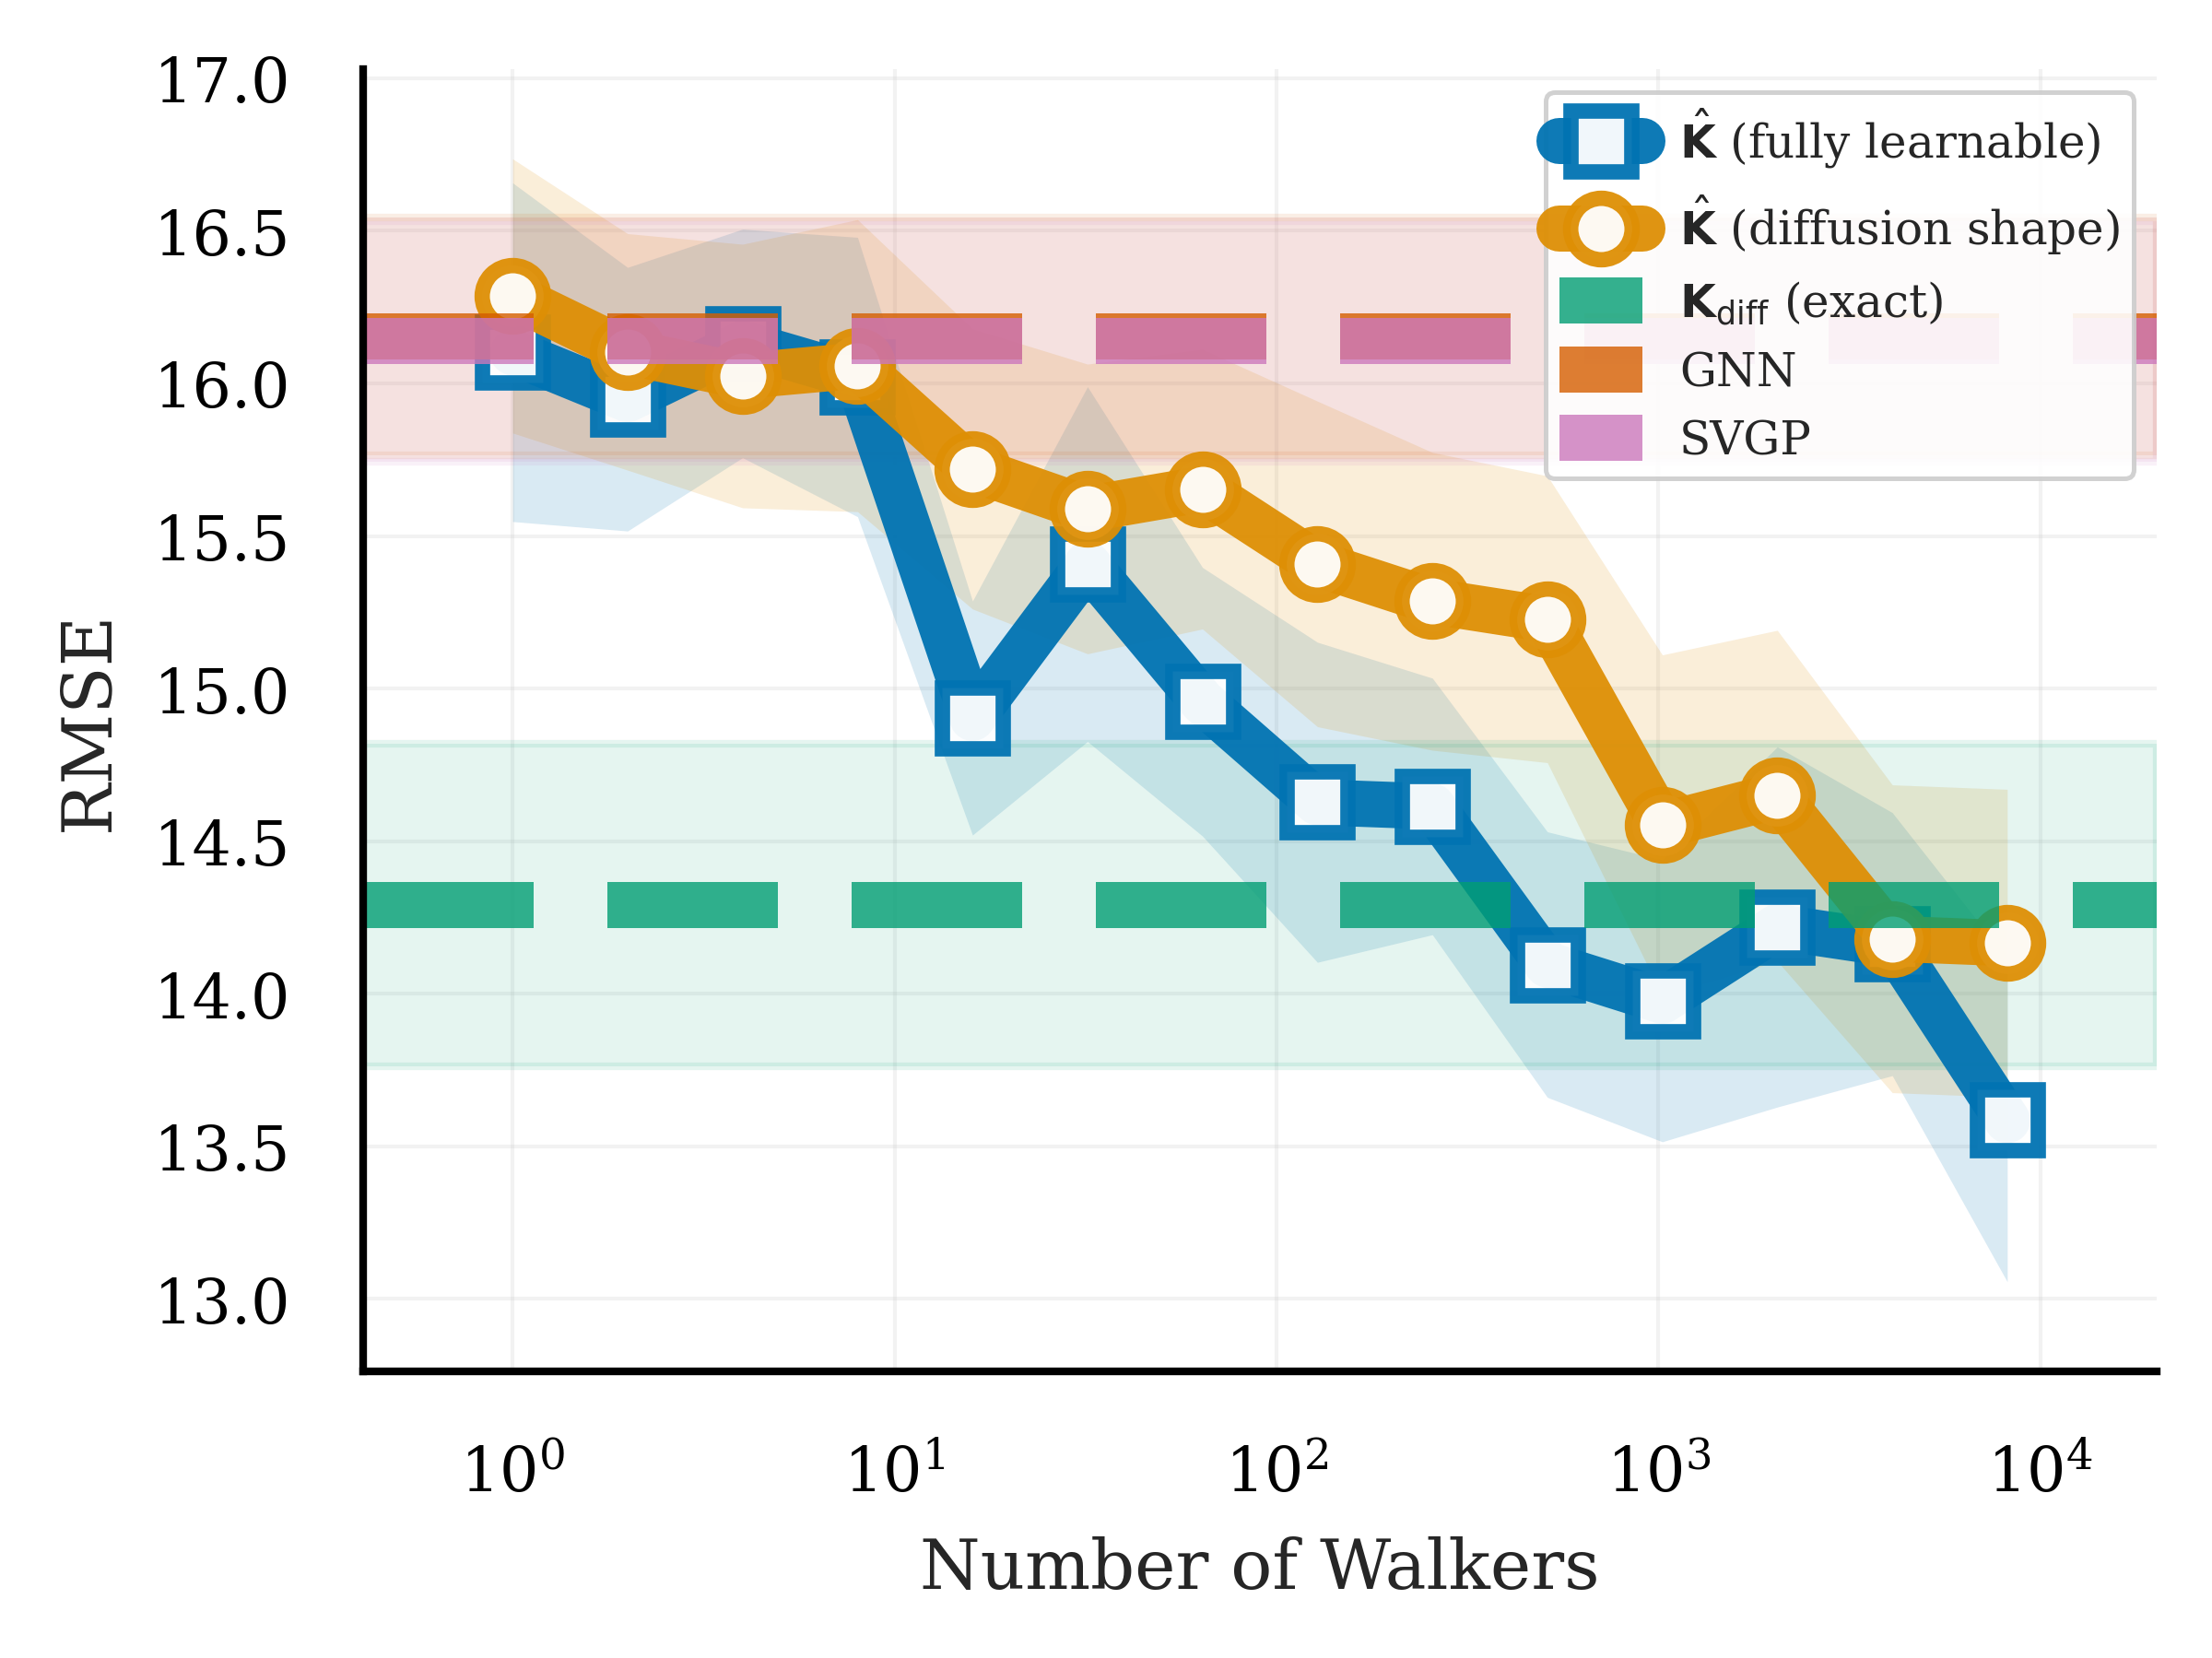

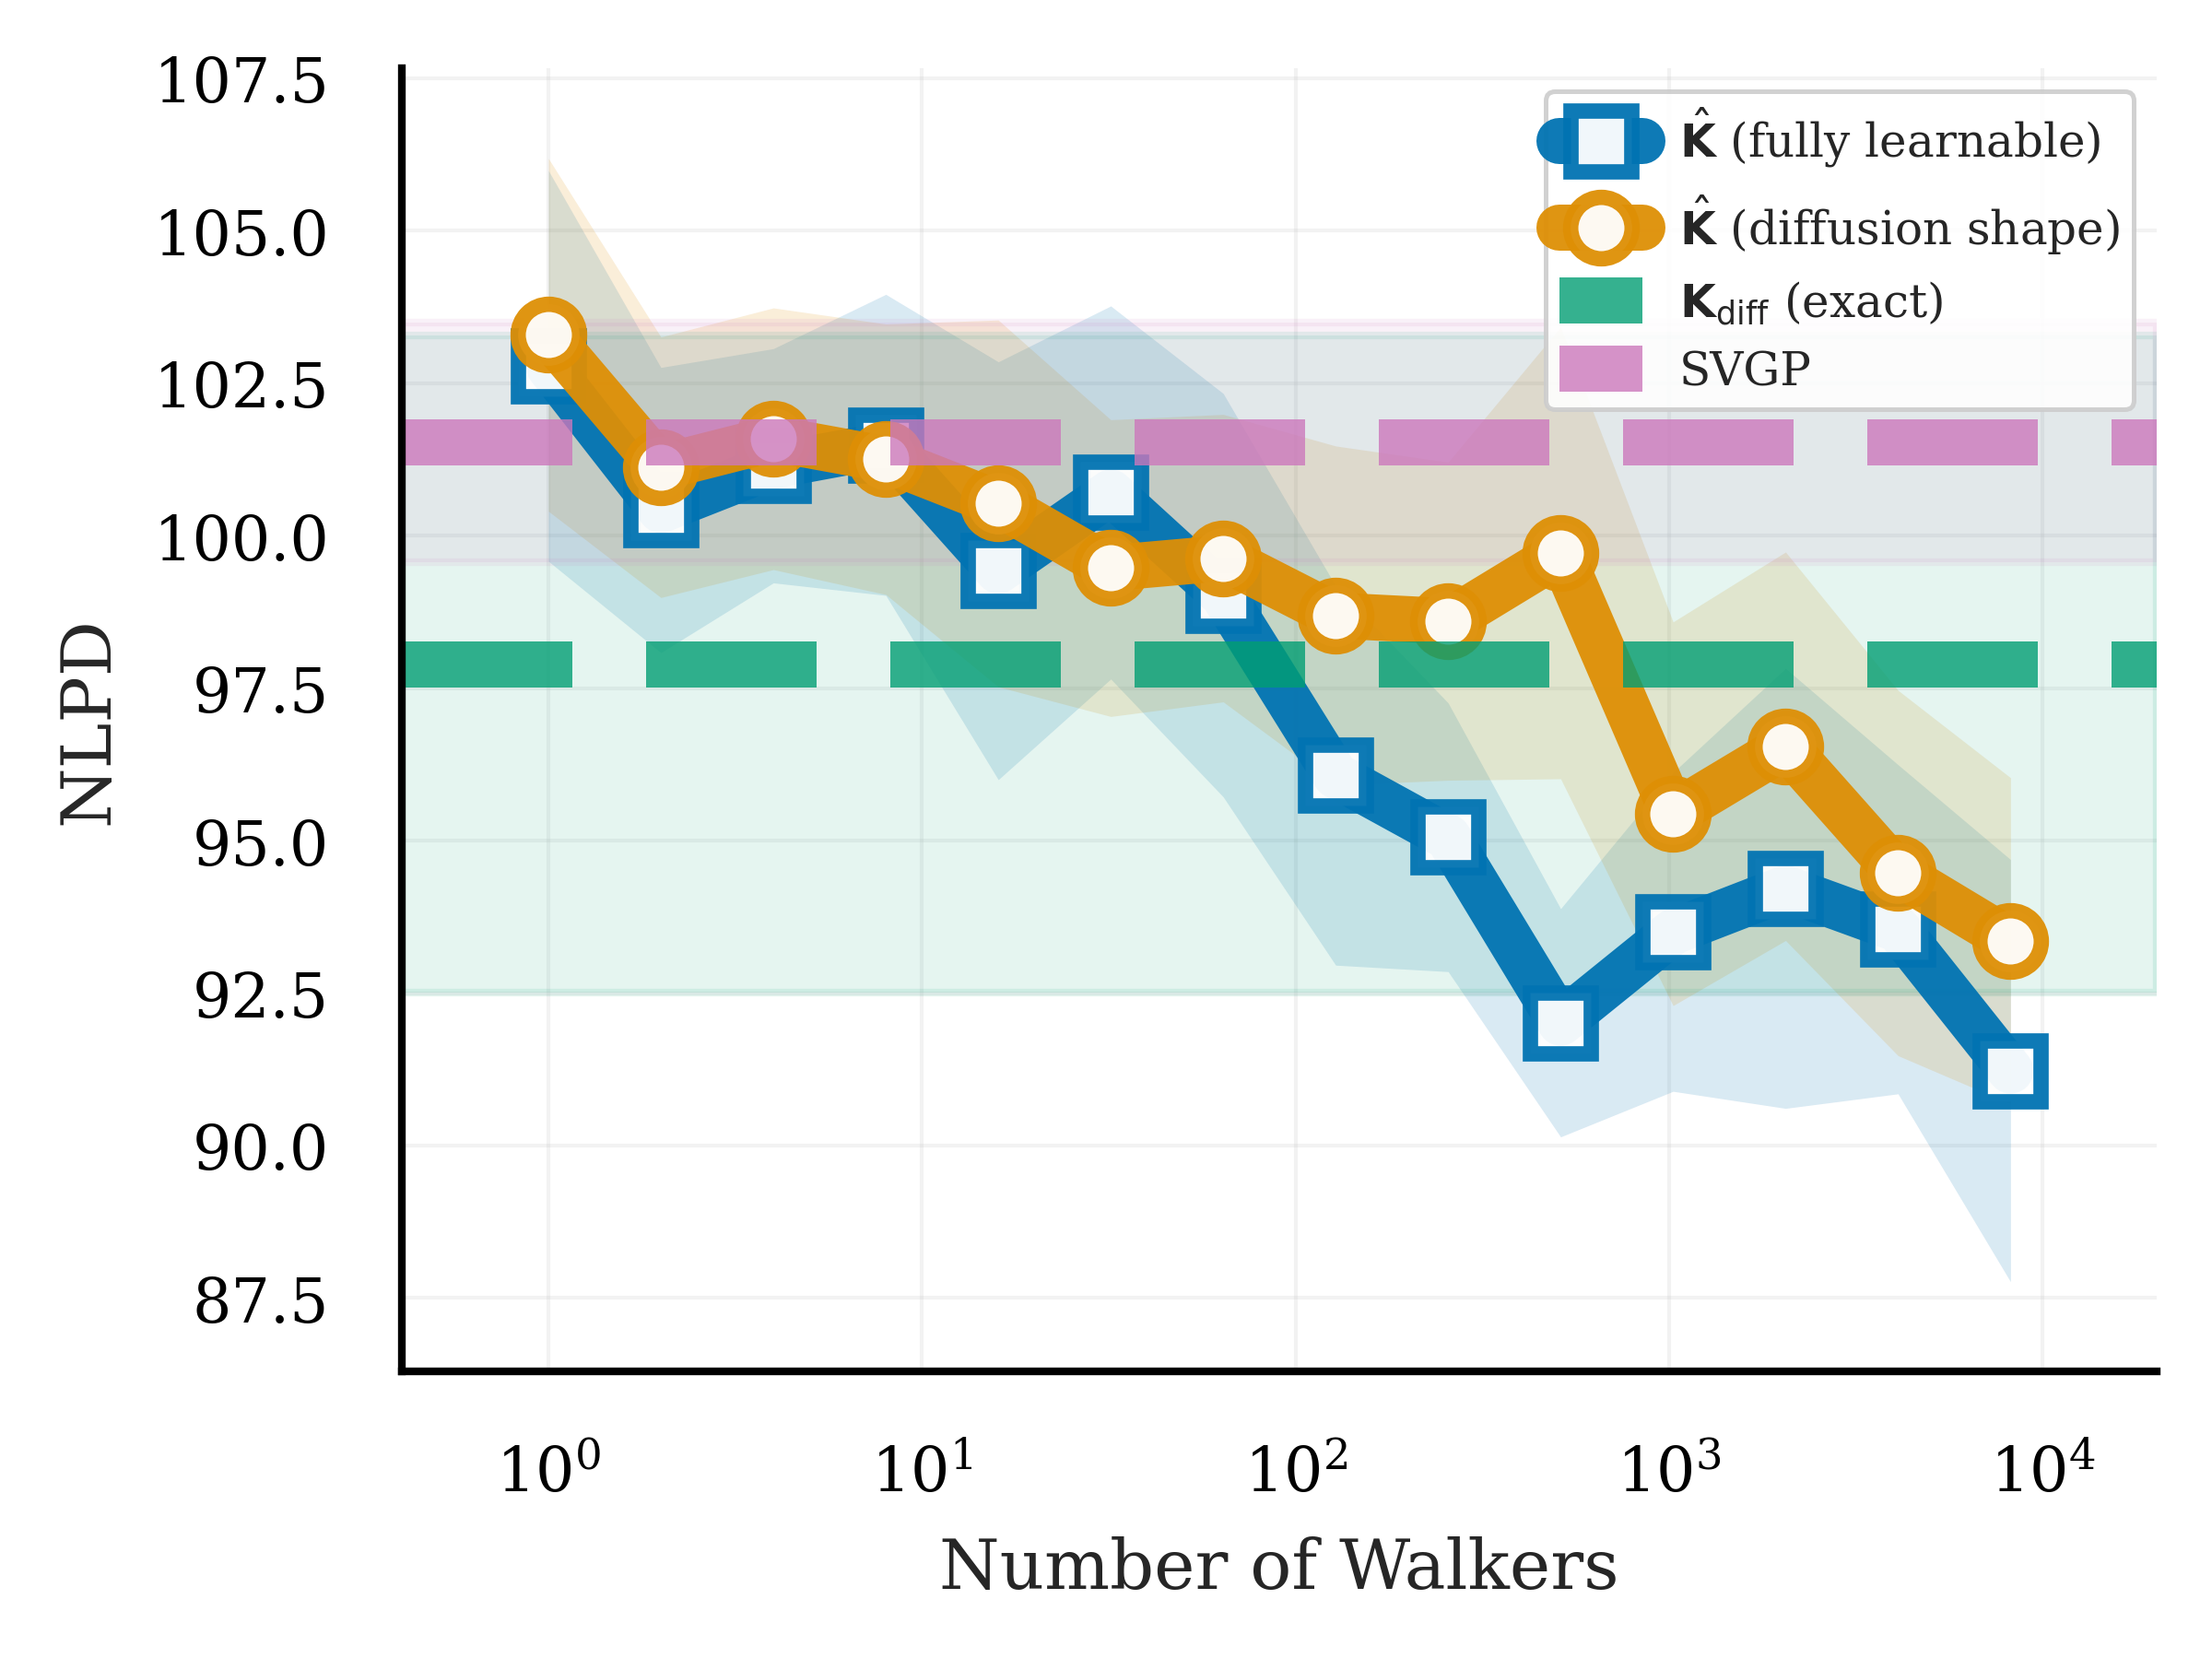

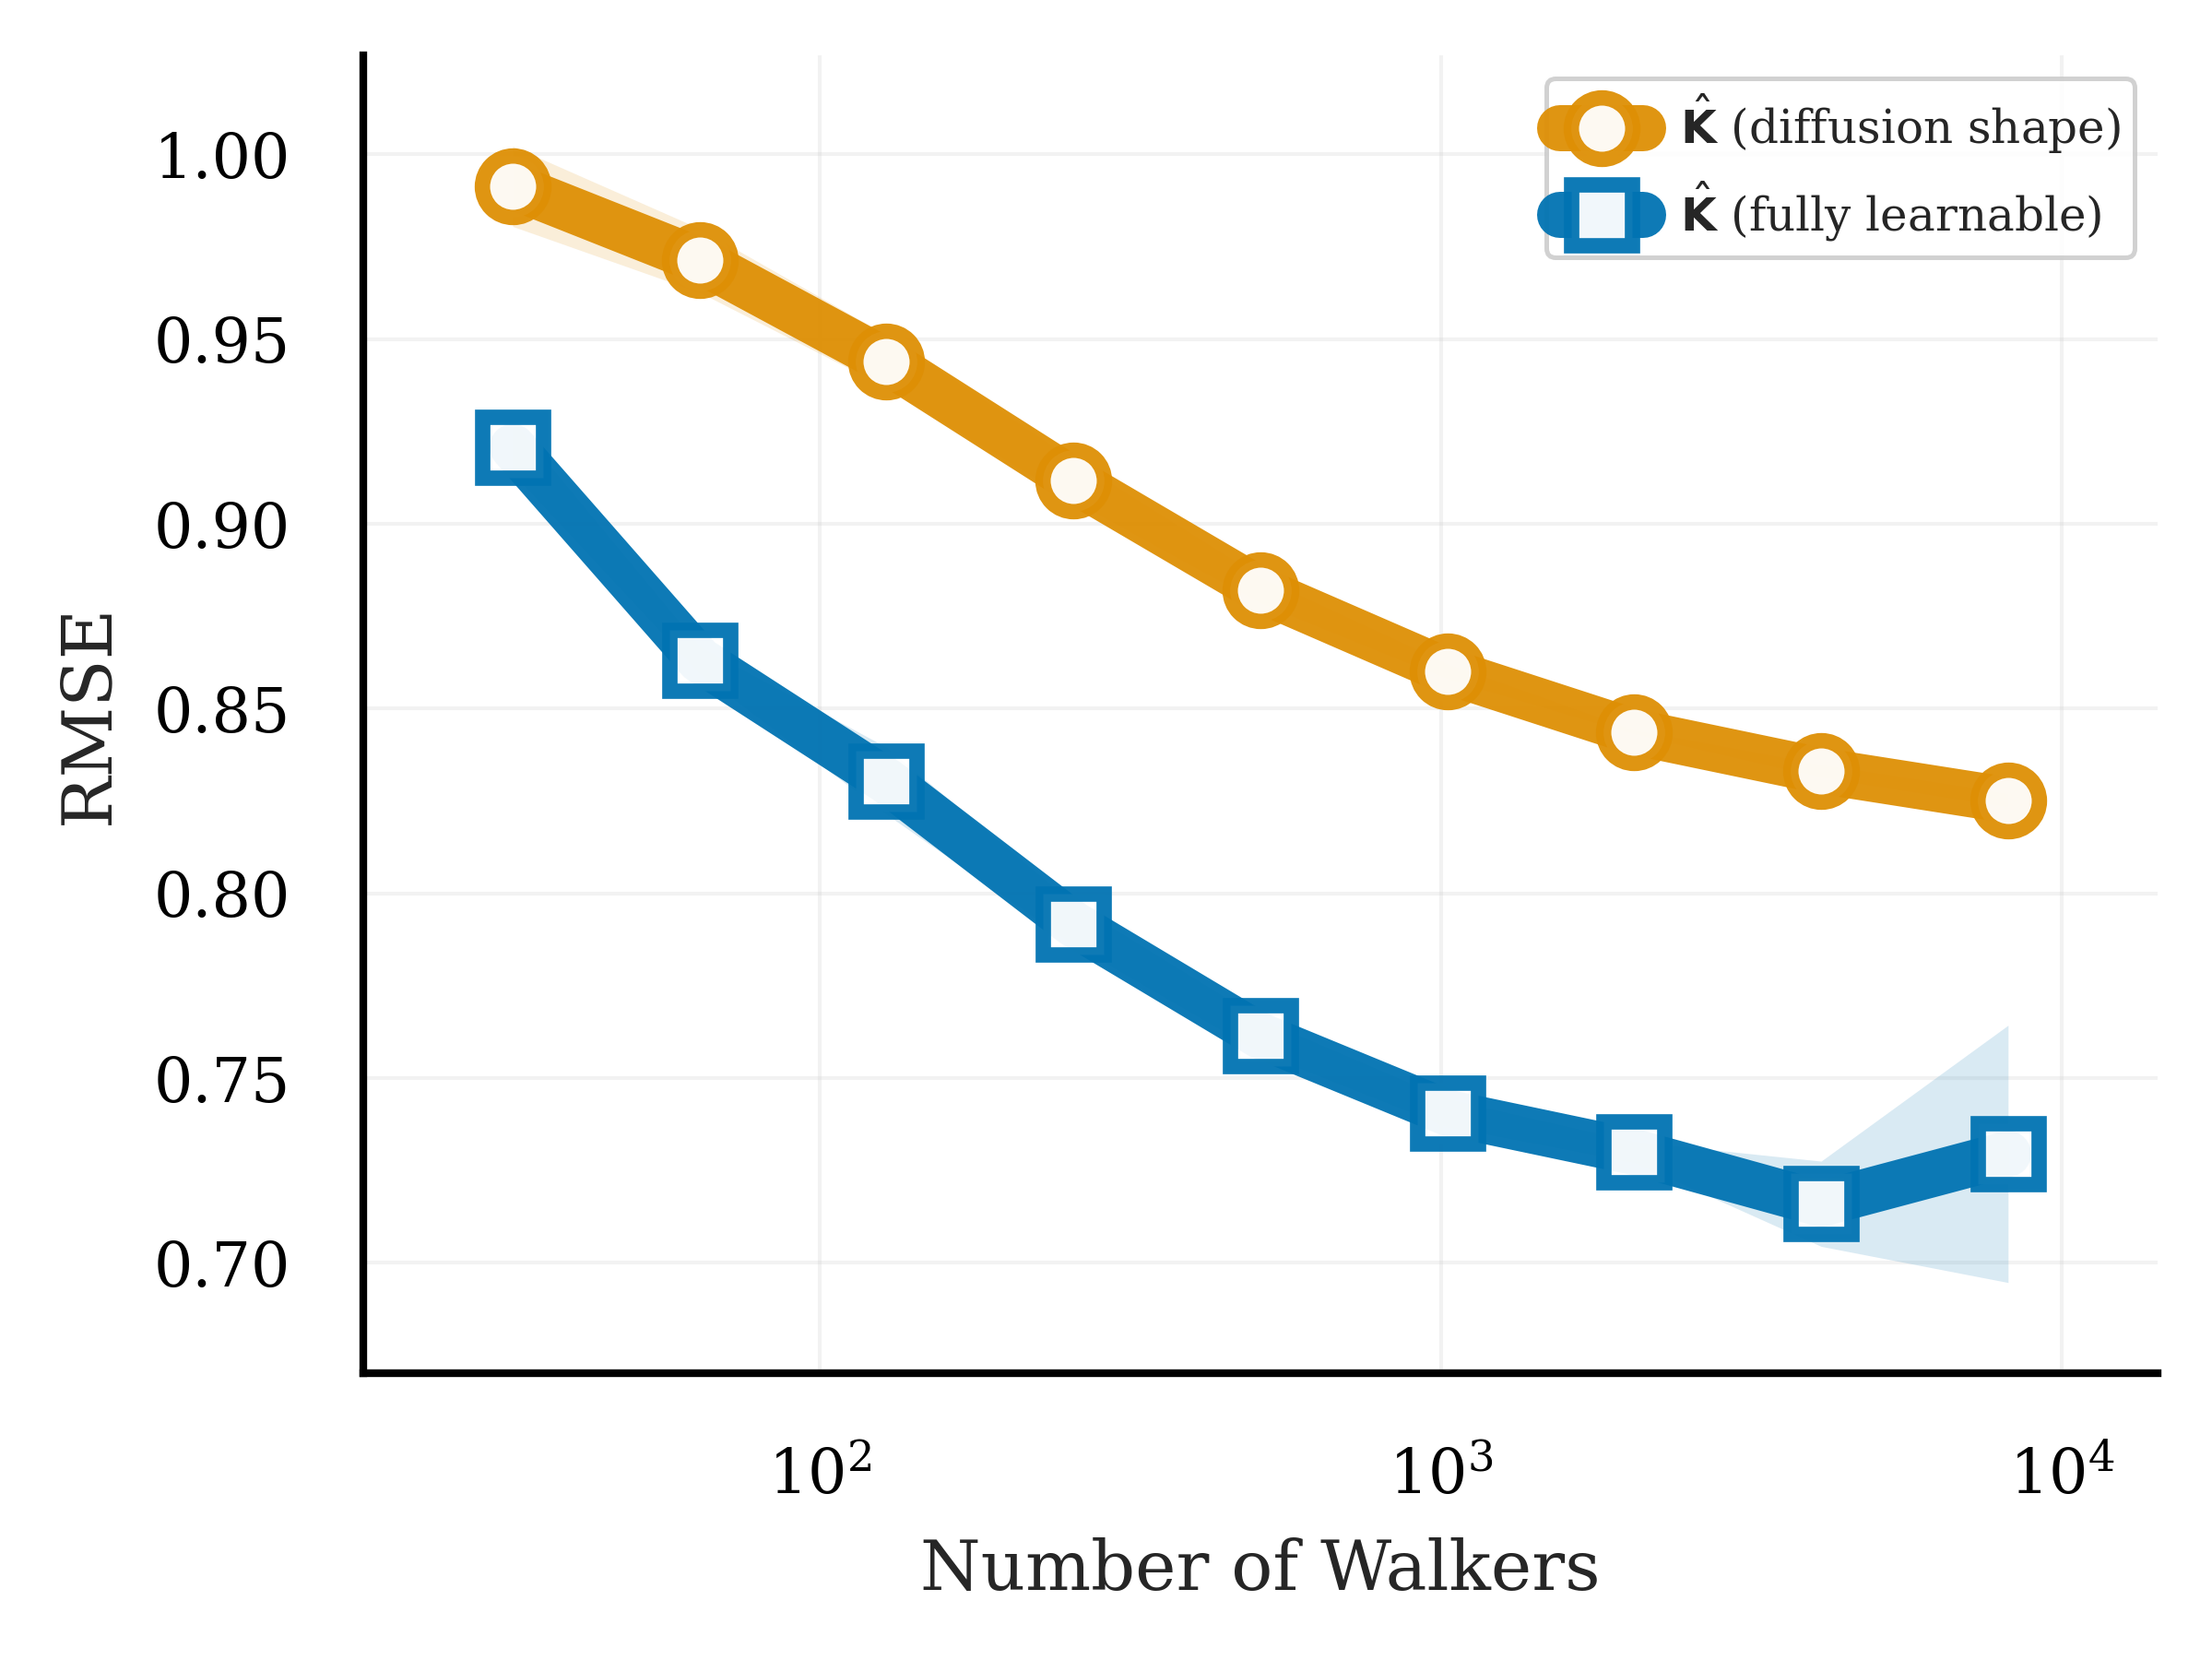

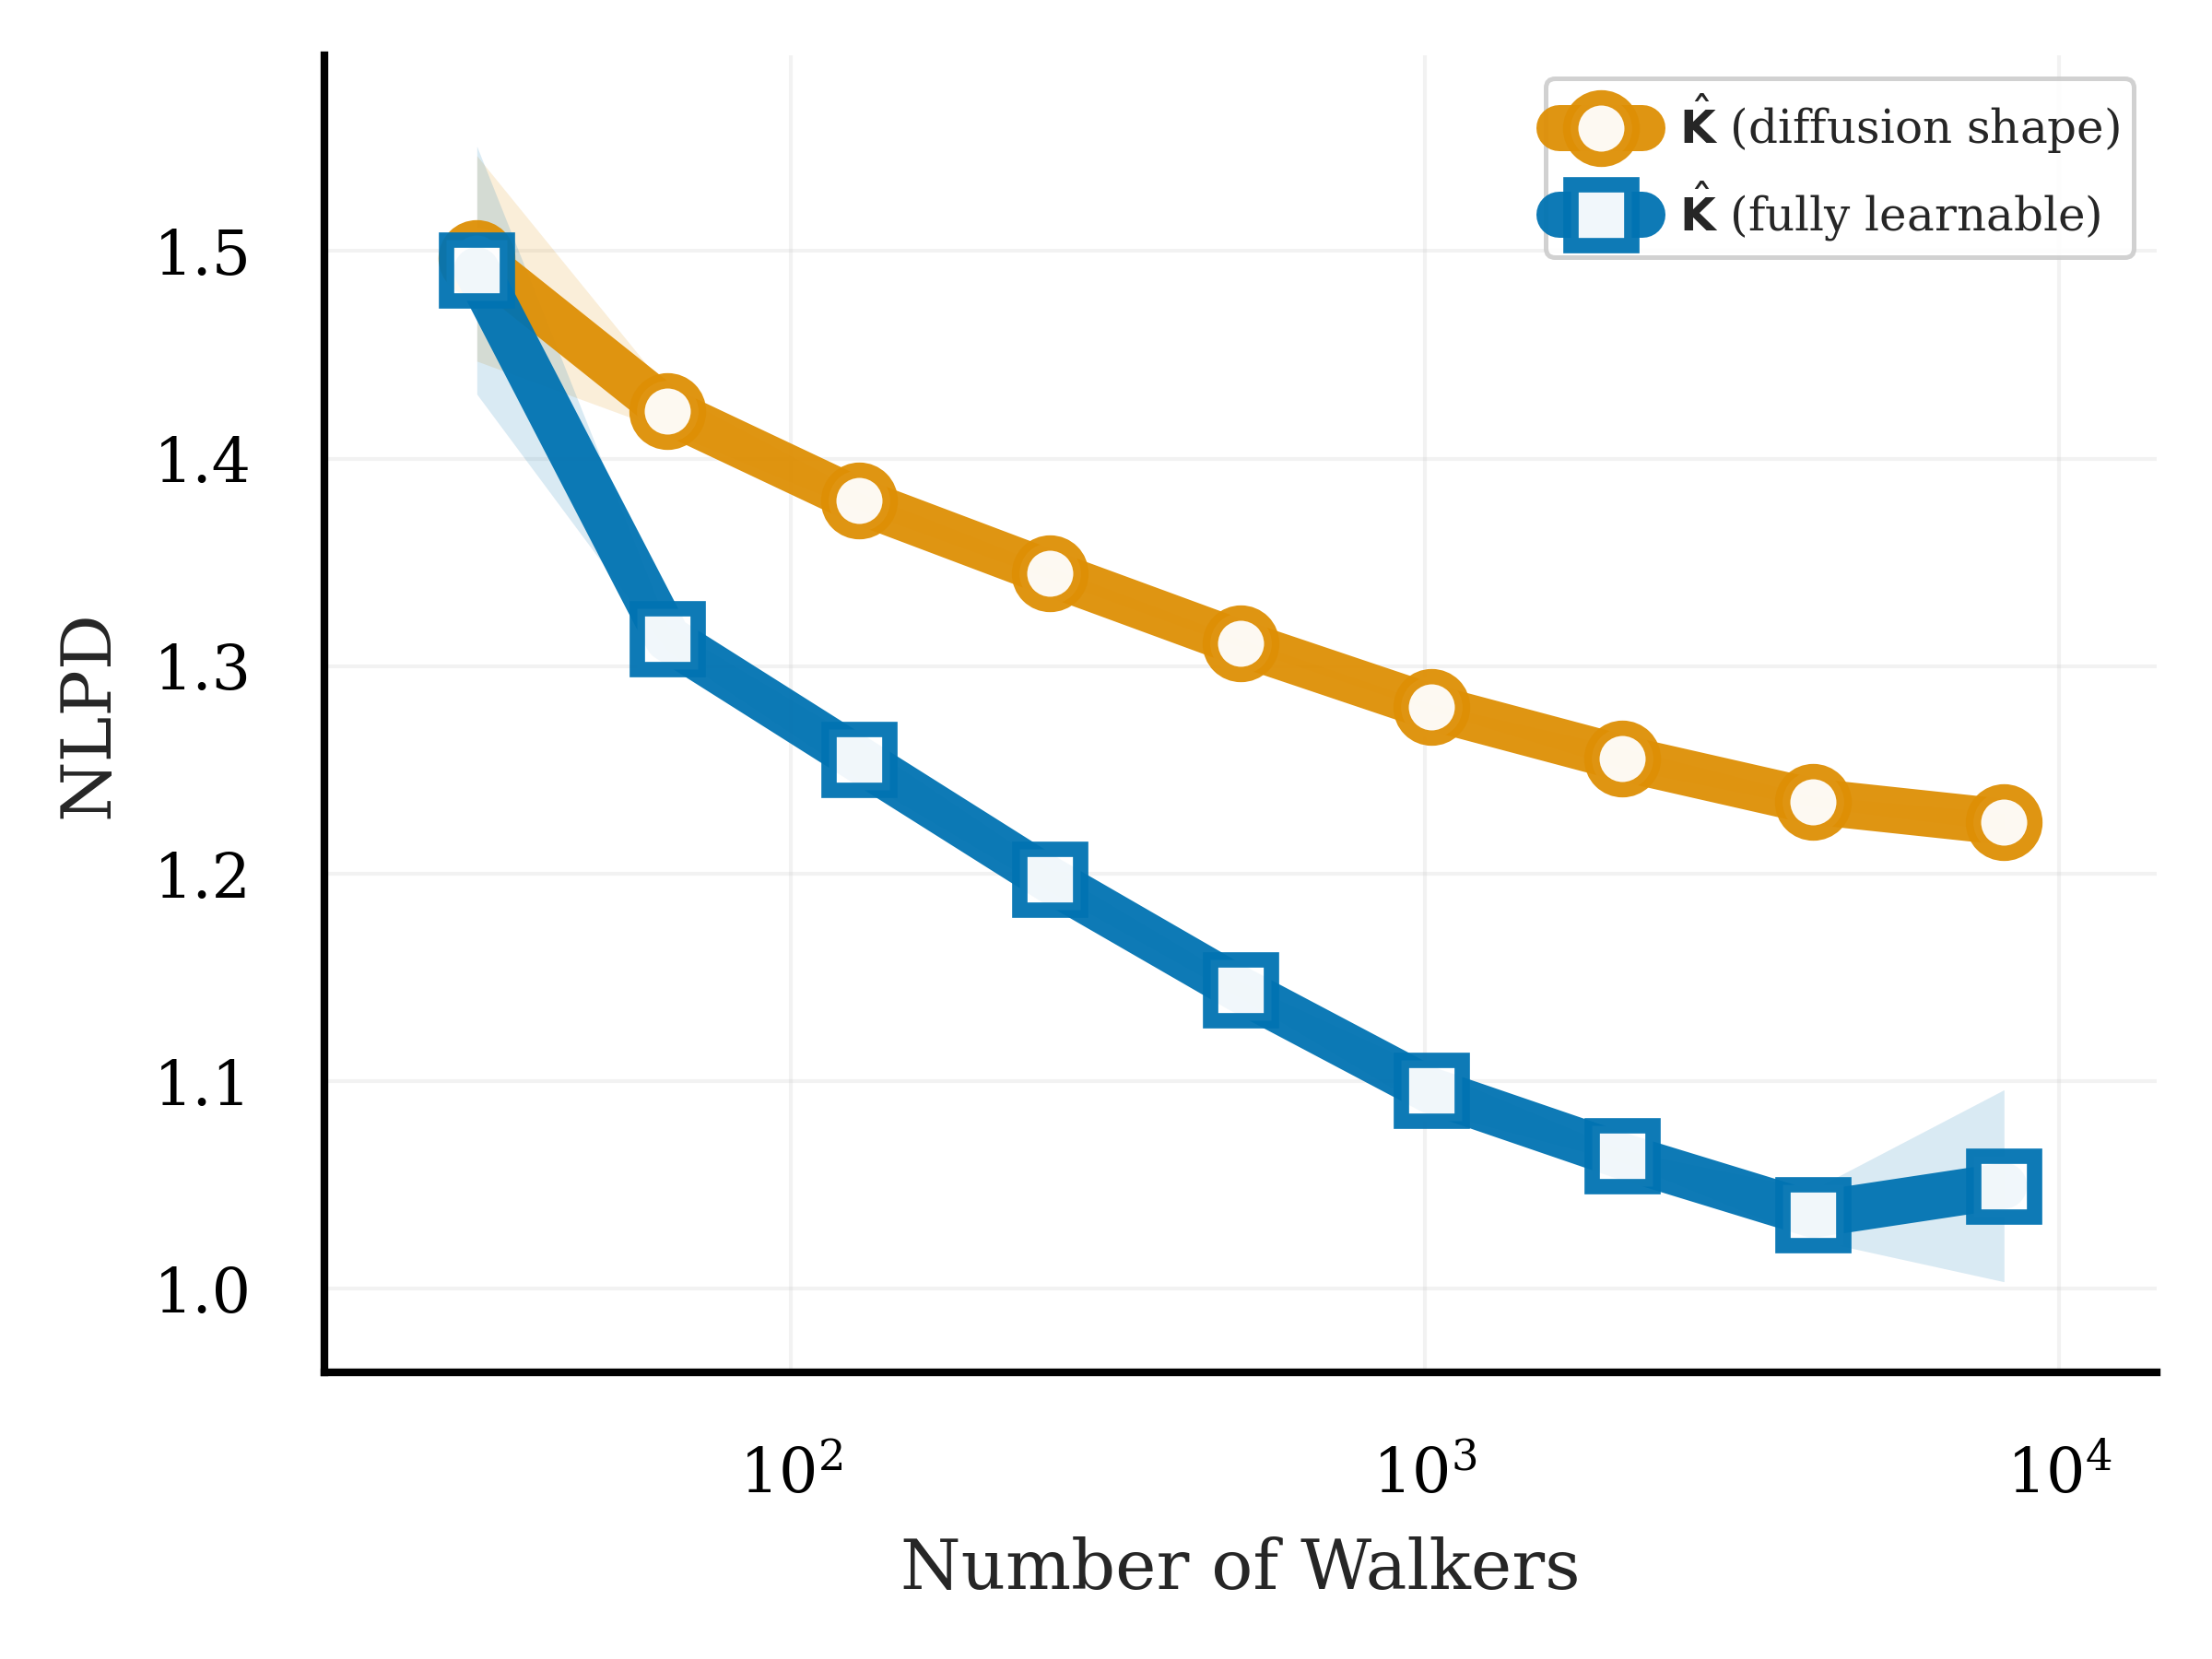

In [56]:
def plot_individual_plots(wind_stats, traffic_grf_stats=None, traffic_baseline_stats=None, figsize=(4, 3)):
    """Plot all four plots individually without subplot labels"""
    # Set publication-style formatting (same as your reference)
    import matplotlib as mpl
    from matplotlib.colors import to_hex
    mpl.rcParams.update({
        "figure.dpi": 600,
        "savefig.dpi": 600,
        "savefig.bbox": "tight",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "font.size": 9,
        "axes.titlesize": 9,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 6,
        "axes.linewidth": 1.0,
        "grid.linewidth": 0.5,
        "grid.alpha": 0.25,
        "axes.axisbelow": True,
        "axes.edgecolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    
    # Wide line/marker settings for small panels
    LW_DATA = 6
    MS = 8
    MEW = 2
    
    # Define marker shapes and labels for each model
    model_config = {
        'SparseGRF': {'marker': 's', 'label': r"$\hat{\mathbf{K}}$ (fully learnable)"},
        'SparseDiffusion': {'marker': 'o', 'label': r"$\hat{\mathbf{K}}$ (diffusion shape)"},
        'GRF': {'marker': 'o', 'label': r"$\hat{\mathbf{K}}$ (diffusion shape)"},
        'A-GRF': {'marker': 's', 'label': r"$\hat{\mathbf{K}}$ (fully learnable)"},
        'PoFM': {'marker': '^', 'label': 'PoFM'},
        'Diffusion': {'marker': 'D', 'label': r"$\mathbf{K}_{\text{diff}}$ (exact)"},
        'SVGP': {'marker': 'D', 'label': 'SVGP'},
        'GCN': {'marker': 'D', 'label':'GNN'},
    }
    
    def sort_legend_items(ax):
        """Sort legend items by priority"""
        handles, labels = ax.get_legend_handles_labels()
        legend_items = []
        for handle, label in zip(handles, labels):
            if "fully learnable" in label:
                priority = 1
            elif "diffusion shape" in label:
                priority = 2
            else:
                priority = 3
            legend_items.append((handle, label, priority))
        
        legend_items.sort(key=lambda x: x[2])
        sorted_handles, sorted_labels = zip(*[(item[0], item[1]) for item in legend_items])
        return sorted_handles, sorted_labels
    
    def finish_axes_linear(ax, xlab, ylab):
        """Format axes with log x-axis but linear y-axis"""
        ax.set_xscale('log')
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.grid(True, which='major', axis='both')
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        
        # Legend styling
        leg = ax.legend(loc='upper right', frameon=True, framealpha=0.9,
                       fancybox=True, borderpad=0.3, handlelength=1.8, fontsize=6)
        leg.get_frame().set_linewidth(0.6)
        ax.margins(x=0.10, y=0.08)
        plt.tight_layout(pad=0.8)
    
    # Plot 1: Traffic RMSE
    if traffic_grf_stats is not None or traffic_baseline_stats is not None:
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot traffic GRF models
        if traffic_grf_stats is not None:
            for model in traffic_grf_stats['model'].unique():
                model_data = traffic_grf_stats[traffic_grf_stats['model'] == model].sort_values('walks_per_node')
                config = model_config.get(model, {'marker': 'o', 'label': model})
                
                x = model_data['walks_per_node'].to_numpy()
                y = model_data['rmse_mean'].to_numpy()
                yerr = model_data['rmse_stderr'].to_numpy()
                
                # Shaded error band first (no legend entry)
                ax.fill_between(
                    x, y - yerr, y + yerr,
                    color=COLOR_MAPPING.get(model, 'gray'), alpha=0.15, linewidth=0, zorder=1
                )
                
                # Mean curve on top
                ax.plot(
                    x, y,
                    marker=config['marker'], markersize=MS, markerfacecolor='white', markeredgewidth=MEW,
                    linestyle='-', linewidth=LW_DATA, color=COLOR_MAPPING.get(model, 'gray'), alpha=0.95,
                    label=config['label'], zorder=2
                )
        
        # Plot traffic baseline horizontal lines
        if traffic_baseline_stats is not None:
            for _, row in traffic_baseline_stats.iterrows():
                model = row['model']
                mean_val = row['rmse_mean']
                stderr_val = row['rmse_stderr']
                config = model_config.get(model, {'label': f"{model} (exact)"})
                
                ax.axhline(
                    y=mean_val, 
                    color=COLOR_MAPPING.get(model, 'gray'), 
                    linestyle='--', 
                    linewidth=LW_DATA,
                    alpha=0.8,
                    label=config['label']
                )
                
                if stderr_val > 0:
                    ax.axhspan(
                        mean_val - stderr_val, 
                        mean_val + stderr_val, 
                        alpha=0.1, 
                        color=COLOR_MAPPING.get(model, 'gray')
                    )
        
        finish_axes_linear(ax, 'Number of Walkers', 'RMSE')
        plt.show()
    
    # Plot 2: Traffic NLPD
    if traffic_grf_stats is not None or traffic_baseline_stats is not None:
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot traffic GRF models
        if traffic_grf_stats is not None:
            for model in traffic_grf_stats['model'].unique():
                model_data = traffic_grf_stats[traffic_grf_stats['model'] == model].sort_values('walks_per_node')
                config = model_config.get(model, {'marker': 'o', 'label': model})
                
                x = model_data['walks_per_node'].to_numpy()
                y = model_data['nlpd_mean'].to_numpy()
                yerr = model_data['nlpd_stderr'].to_numpy()
                
                # Shaded error band first (no legend entry)
                ax.fill_between(
                    x, y - yerr, y + yerr,
                    color=COLOR_MAPPING.get(model, 'gray'), alpha=0.15, linewidth=0, zorder=1
                )
                
                # Mean curve on top
                ax.plot(
                    x, y,
                    marker=config['marker'], markersize=MS, markerfacecolor='white', markeredgewidth=MEW,
                    linestyle='-', linewidth=LW_DATA, color=COLOR_MAPPING.get(model, 'gray'), alpha=0.95,
                    label=config['label'], zorder=2
                )
        
        # Plot traffic baseline horizontal lines (exclude GCN)
        if traffic_baseline_stats is not None:
            for _, row in traffic_baseline_stats.iterrows():
                model = row['model']
                if model == 'GCN':  # Skip GCN for NLPD plot
                    continue
                mean_val = row['nlpd_mean']
                stderr_val = row['nlpd_stderr']
                config = model_config.get(model, {'label': f"{model} (exact)"})
                
                ax.axhline(
                    y=mean_val, 
                    color=COLOR_MAPPING.get(model, 'gray'), 
                    linestyle='--', 
                    linewidth=LW_DATA,
                    alpha=0.8,
                    label=config['label']
                )
                
                if stderr_val > 0:
                    ax.axhspan(
                        mean_val - stderr_val, 
                        mean_val + stderr_val, 
                        alpha=0.1, 
                        color=COLOR_MAPPING.get(model, 'gray')
                    )
        
        finish_axes_linear(ax, 'Number of Walkers', 'NLPD')
        plt.show()
    
    # Plot 3: Wind RMSE
    if wind_stats is not None:
        fig, ax = plt.subplots(figsize=figsize)
        
        for model in wind_stats['model'].unique():
            model_data = wind_stats[wind_stats['model'] == model].sort_values('walks_per_node')
            config = model_config.get(model, {'marker': 'o', 'label': model})
            
            x = model_data['walks_per_node'].to_numpy()
            y = model_data['rmse_mean'].to_numpy()
            yerr = (2 * model_data['rmse_stderr']).to_numpy()  # 2x error for wind dataset
            
            # Shaded error band first (no legend entry)
            ax.fill_between(
                x, y - yerr, y + yerr,
                color=COLOR_MAPPING.get(model, 'gray'), alpha=0.15, linewidth=0, zorder=1
            )
            
            # Mean curve on top
            ax.plot(
                x, y,
                marker=config['marker'], markersize=MS, markerfacecolor='white', markeredgewidth=MEW,
                linestyle='-', linewidth=LW_DATA, color=COLOR_MAPPING.get(model, 'gray'), alpha=0.95,
                label=config['label'], zorder=2
            )
        
        finish_axes_linear(ax, 'Number of Walkers', 'RMSE')
        plt.show()
    
    # Plot 4: Wind NLPD
    if wind_stats is not None:
        fig, ax = plt.subplots(figsize=figsize)
        
        # Filter out GCN if it exists in wind_stats
        for model in wind_stats['model'].unique():
            if model == 'GCN':  # Skip GCN for NLPD plot
                continue
            model_data = wind_stats[wind_stats['model'] == model].sort_values('walks_per_node')
            config = model_config.get(model, {'marker': 'o', 'label': model})
            
            x = model_data['walks_per_node'].to_numpy()
            y = model_data['nlpd_mean'].to_numpy()
            yerr = (2 * model_data['nlpd_stderr']).to_numpy()  # 2x error for wind dataset
            
            # Shaded error band first (no legend entry)
            ax.fill_between(
                x, y - yerr, y + yerr,
                color=COLOR_MAPPING.get(model, 'gray'), alpha=0.15, linewidth=0, zorder=1
            )
            
            # Mean curve on top
            ax.plot(
                x, y,
                marker=config['marker'], markersize=MS, markerfacecolor='white', markeredgewidth=MEW,
                linestyle='-', linewidth=LW_DATA, color=COLOR_MAPPING.get(model, 'gray'), alpha=0.95,
                label=config['label'], zorder=2
            )
        
        finish_axes_linear(ax, 'Number of Walkers', 'NLPD')
        plt.show()

# Generate all individual plots
if df is not None and wind_stats is not None:
    plot_individual_plots(wind_stats, traffic_grf_stats, traffic_baseline_stats)
else:
    print("No data available for individual plots")